# Preparation

In [1]:
import cv2
import json
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import shutil

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix, f1_score

In [2]:
raw_images_dir = 'Dataset/1. Raw'
annotations_file = 'Dataset/1. Raw/_annotations.coco.json'
crop_images_dir = 'Dataset/2. Cropped'
augmented_images_dir = 'Dataset/3. Augmented'
threshold_images_dir = 'Dataset/4. Threshold'
balanced_images_dir = 'Dataset/5. Balanced'

categories = {
    1: '0', 2: '1', 3: '2', 4: '3', 5: '4', 6: '5', 7: '6', 8: '7', 9: '8', 10: '9',
    11: 'A', 12: 'B', 13: 'C', 14: 'D', 15: 'E', 16: 'F', 17: 'G', 18: 'H', 19: 'I',
    20: 'J', 21: 'K', 22: 'L', 23: 'M', 24: 'N', 25: 'O', 26: 'P', 27: 'Q', 28: 'R',
    29: 'S', 30: 'T', 31: 'U', 32: 'V', 33: 'W', 34: 'X', 35: 'Y', 36: 'Z'
}

# Preprocessing

In [10]:
def crop_images_with_json(raw_images_dir, annotations_file, crop_images_dir, categories):
    # Membuat folder output jika belum ada
    os.makedirs(crop_images_dir, exist_ok=True)

    # Baca file anotasi JSON
    with open(annotations_file, 'r') as f:
        annotations_data = json.load(f)  # Mengurai file JSON

    # Loop melalui setiap entry dalam file anotasi
    for annotation in annotations_data['annotations']:
        image_id = annotation['image_id']
        category_id = annotation['category_id']
        bbox = annotation['bbox']  # Format bbox: [x, y, width, height]
        
        # Temukan nama file gambar berdasarkan image_id
        image_filename = None
        for image in annotations_data['images']:
            if image['id'] == image_id:
                image_filename = image['file_name']
                break
        
        if image_filename is None:
            print(f"Warning: Image file not found for image_id {image_id}. Skipping.")
            continue  # Lewati jika tidak ditemukan nama file gambar
        
        # Baca gambar menggunakan OpenCV
        image_path = os.path.join(raw_images_dir, image_filename)
        
        try:
            image = cv2.imread(image_path)
        except Exception as e:
            print(f"Error: Failed to read image file {image_path}. Skipping. Error: {e}")
            continue  # Lewati jika gagal membaca gambar

        if image is None:
            print(f"Error: Empty image loaded from file {image_path}. Skipping.")
            continue  # Lewati jika gambar kosong

        # Dapatkan koordinat bounding box
        x, y, width, height = map(int, bbox)

        # Mengcrop gambar sesuai dengan bounding box
        cropped_image = image[y:y+height, x:x+width]

        # Dapatkan nama kategori berdasarkan category_id
        category_name = categories.get(category_id, f"unknown_category_{category_id}")

        # Simpan gambar ke folder output dengan nama folder berdasarkan kategori
        category_dir = os.path.join(crop_images_dir, category_name)
        os.makedirs(category_dir, exist_ok=True)
        output_image_path = os.path.join(category_dir, image_filename)
        
        try:
            cv2.imwrite(output_image_path, cropped_image)
        except Exception as e:
            print(f"Error: Failed to save image {output_image_path}. Error: {e}")

    print("Crop dan save selesai.")

In [11]:
crop_images_with_json(raw_images_dir, annotations_file, crop_images_dir, categories)

Crop dan save selesai.


In [12]:
def augment_image(image, rotation_range=(-5, 5), shear_range=10, brightness_range=(-15, 15), blur_max=2.5):
    # Rotation
    angle = np.random.randint(rotation_range[0], rotation_range[1] + 1)
    rows, cols = image.shape[:2]
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    rotated_image = cv2.warpAffine(image, M, (cols, rows), borderMode=cv2.BORDER_REFLECT)

    # Shear
    shear_horizontal = np.random.randint(-shear_range, shear_range + 1)
    shear_vertical = np.random.randint(-shear_range, shear_range + 1)
    shear_matrix = np.array([[1, shear_horizontal / 100., 0], [shear_vertical / 100., 1, 0]])
    sheared_image = cv2.warpAffine(rotated_image, shear_matrix, (cols, rows), borderMode=cv2.BORDER_REFLECT)

    # Brightness adjustment
    brightness_value = np.random.randint(brightness_range[0], brightness_range[1] + 1)
    bright_image = np.clip(sheared_image.astype(int) + brightness_value, 0, 255).astype(np.uint8)

    # Blur
    blur_value = random.uniform(0, blur_max)
    blurred_image = cv2.GaussianBlur(bright_image, (5, 5), blur_value)

    return blurred_image

In [13]:
def augment_and_save_images(crop_images_dir, augmented_images_dir, rotation_range=(-5, 5), shear_range=10, 
                            brightness_range=(-15, 15), blur_max=2.5):
    # Create the output directory if it does not exist
    os.makedirs(augmented_images_dir, exist_ok=True)

    # Iterate through each subdirectory (category) in the input directory (crop_images_dir)
    for root, dirs, files in os.walk(crop_images_dir):
        for category_name in dirs:
            category_dir = os.path.join(root, category_name)

            # Create a subfolder in the output directory for the category
            output_category_dir = os.path.join(augmented_images_dir, category_name)
            os.makedirs(output_category_dir, exist_ok=True)

            # Loop through each image file in the subfolder (category)
            for filename in os.listdir(category_dir):
                if filename.endswith(('.jpg', '.jpeg', '.png')):
                    # Read the image using OpenCV
                    image_path = os.path.join(category_dir, filename)
                    image = cv2.imread(image_path)

                    if image is None:
                        print(f"Error: Failed to read image file {image_path}. Skipping.")
                        continue

                    # Perform image augmentation
                    augmented_image = augment_image(image, rotation_range, shear_range, brightness_range, blur_max)

                    # Save the original image
                    original_output_path = os.path.join(output_category_dir, f"original_{filename}")
                    cv2.imwrite(original_output_path, image)

                    # Save the augmented image
                    augmented_output_path = os.path.join(output_category_dir, f"augmented_{filename}")
                    cv2.imwrite(augmented_output_path, augmented_image)

    print("Augmentation and saving completed.")

In [14]:
augment_and_save_images(crop_images_dir, augmented_images_dir, 
                        rotation_range=(-5, 5), shear_range=10, 
                        brightness_range=(-15, 15), blur_max=3)


Augmentation and saving completed.


In [15]:
def preprocess_image(img_path, target_size=(28, 28)):
    # Load image in grayscale
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    # Apply thresholding to create binary image
    _, thresh = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Resize image to target size
    resized_img = cv2.resize(thresh, target_size)
    
    return resized_img

In [16]:
def process_dataset(dataset_dir, save_base_dir):
    # Iterate through subfolders (0-9, A-Z)
    for folder_name in os.listdir(dataset_dir):
        folder_path = os.path.join(dataset_dir, folder_name)
        
        # Check if it's a directory
        if os.path.isdir(folder_path):
            label = folder_name  # Subfolder name is the label
            
            # Create directory for current label in save_base_dir
            save_dir = os.path.join(save_base_dir, label)
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
            
            # Iterate through images in the subfolder
            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                
                # Load and preprocess the image
                if img_path.endswith('.jpg') or img_path.endswith('.png'):
                    preprocessed_img = preprocess_image(img_path)
                    
                    # Save preprocessed image to the target directory
                    save_path = os.path.join(save_dir, img_name)
                    cv2.imwrite(save_path, preprocessed_img)
                    
    print("Preprocessing and saving completed.")

In [17]:
process_dataset(augmented_images_dir, threshold_images_dir)

Preprocessing and saving completed.


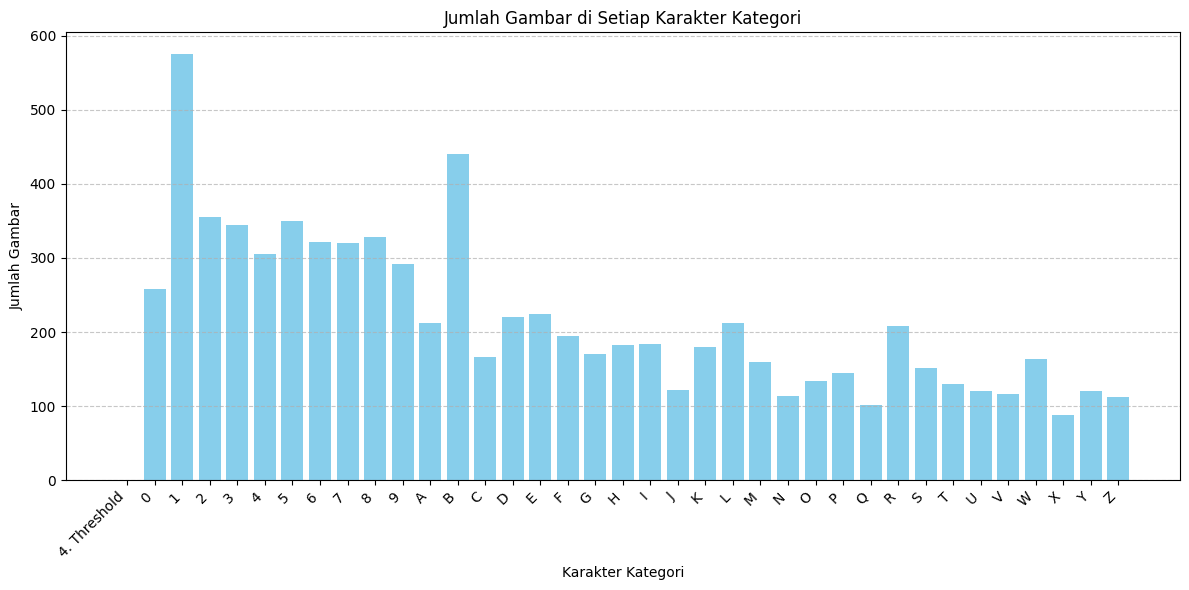

In [18]:
folder_counts = {}

# Iterasi melalui setiap subfolder di crop_images_dir
for root, dirs, files in os.walk(threshold_images_dir):
    folder_name = os.path.basename(root)
    file_count = len([f for f in files if f.endswith(('.jpg', '.jpeg', '.png'))])

    if folder_name not in folder_counts:
        folder_counts[folder_name] = 0
    
    folder_counts[folder_name] += file_count

# Mengambil nama folder dan jumlah file sebagai label dan nilai untuk plot
folder_names = list(folder_counts.keys())
file_counts = list(folder_counts.values())

# Membuat plot menggunakan matplotlib
plt.figure(figsize=(12, 6))
plt.bar(folder_names, file_counts, color='skyblue')
plt.xlabel('Karakter Kategori')
plt.ylabel('Jumlah Gambar')
plt.title('Jumlah Gambar di Setiap Karakter Kategori')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [19]:
def balance_data(input_dir, output_dir, min_images_per_category):
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Iterate over each category (folder) in the input directory
    for category_name in os.listdir(input_dir):
        category_dir = os.path.join(input_dir, category_name)

        if not os.path.isdir(category_dir):
            continue  # Skip if not a directory

        # List all images in the current category
        image_files = [f for f in os.listdir(category_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

        # Determine number of images to sample (minimum between available images and min_images_per_category)
        num_images_to_sample = min(len(image_files), min_images_per_category)

        # Randomly sample images from the current category
        sampled_images = random.sample(image_files, num_images_to_sample)

        # Create a subdirectory in the output directory for the current category
        output_category_dir = os.path.join(output_dir, category_name)
        os.makedirs(output_category_dir, exist_ok=True)

        # Copy sampled images to the output directory
        for image_file in sampled_images:
            src_path = os.path.join(category_dir, image_file)
            dst_path = os.path.join(output_category_dir, image_file)
            shutil.copyfile(src_path, dst_path)

    print("Data balancing completed.")

In [20]:
min_images_per_category = 80
balance_data(threshold_images_dir, balanced_images_dir, min_images_per_category)

Data balancing completed.


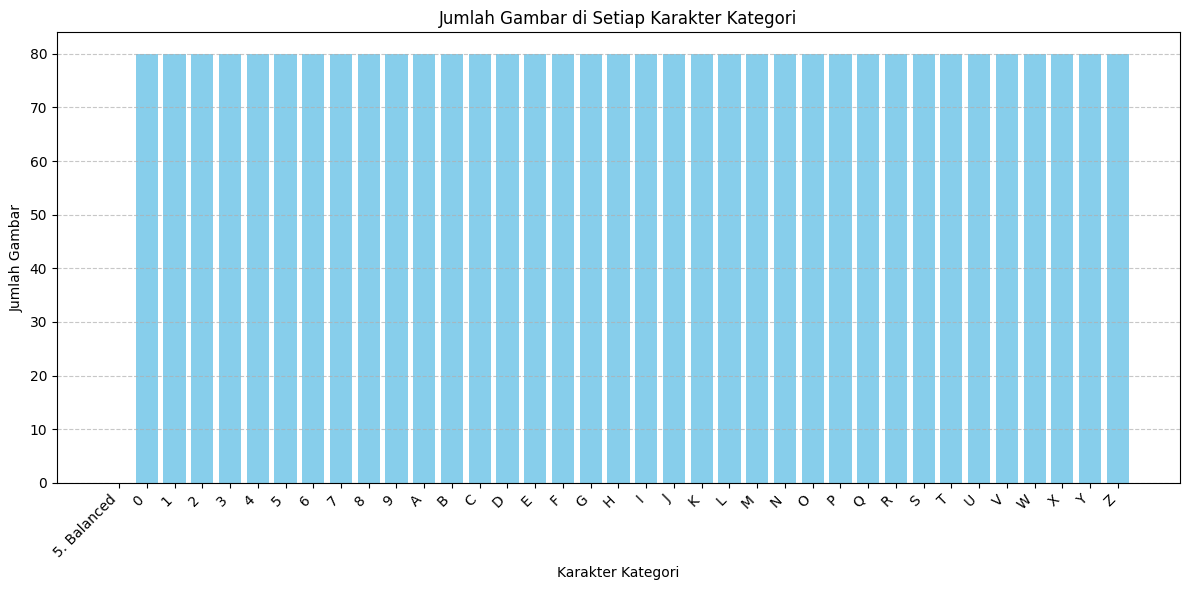

In [21]:
folder_counts = {}

# Iterasi melalui setiap subfolder di crop_images_dir
for root, dirs, files in os.walk(balanced_images_dir):
    folder_name = os.path.basename(root)
    file_count = len([f for f in files if f.endswith(('.jpg', '.jpeg', '.png'))])

    if folder_name not in folder_counts:
        folder_counts[folder_name] = 0
    
    folder_counts[folder_name] += file_count

# Mengambil nama folder dan jumlah file sebagai label dan nilai untuk plot
folder_names = list(folder_counts.keys())
file_counts = list(folder_counts.values())

# Membuat plot menggunakan matplotlib
plt.figure(figsize=(12, 6))
plt.bar(folder_names, file_counts, color='skyblue')
plt.xlabel('Karakter Kategori')
plt.ylabel('Jumlah Gambar')
plt.title('Jumlah Gambar di Setiap Karakter Kategori')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Training

In [4]:
data_dir = "Dataset/5. Balanced"  # training dataset folder

batch_size = 32
img_height = 40
img_width = 40

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

class_names = train_ds.class_names

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Normalize pixel values to [0, 1]
normalization_layer = layers.Rescaling(1./255)

# Apply normalization to the datasets
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

num_classes = 36

model = Sequential([
    layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

# Save the trained model
model.save('..\..\models\charplatevechile_recognition.keras')


Found 2880 files belonging to 36 classes.
Using 2304 files for training.
Found 2880 files belonging to 36 classes.
Using 576 files for validation.


c:\Users\ivann\Downloads\Skripsi\AI\aivenv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 40, 40, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 20, 20, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 20, 20, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 36)             │         4,644 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 233,156 (910.77 KB)

 Trainable params: 233,156 (910.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.1992 - loss: 3.0775 - val_accuracy: 0.8351 - val_loss: 0.5559
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8956 - loss: 0.3404 - val_accuracy: 0.9583 - val_loss: 0.1611
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9689 - loss: 0.1036 - val_accuracy: 0.9757 - val_loss: 0.1219
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9919 - loss: 0.0418 - val_accuracy: 0.9722 - val_loss: 0.1233
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9909 - loss: 0.0396 - val_accuracy: 0.9809 - val_loss: 0.1290
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9954 - loss: 0.0141 - val_accuracy: 0.9722 - val_loss: 0.1051
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9997 - loss: 0.0042 - val_accuracy: 0.9774 - val_loss: 0.0961
Epoch 8/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 0.9826 - v

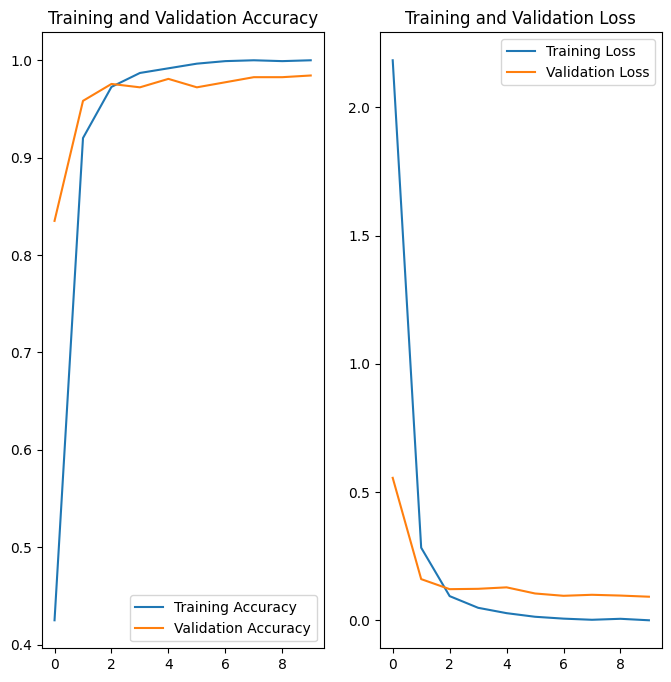

In [5]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [6]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get true labels and predicted labels for the validation dataset
true_labels = []
predicted_labels = []

for images, labels in val_ds:
    true_labels.extend(labels.numpy())
    predictions = model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))

# Calculate confusion matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


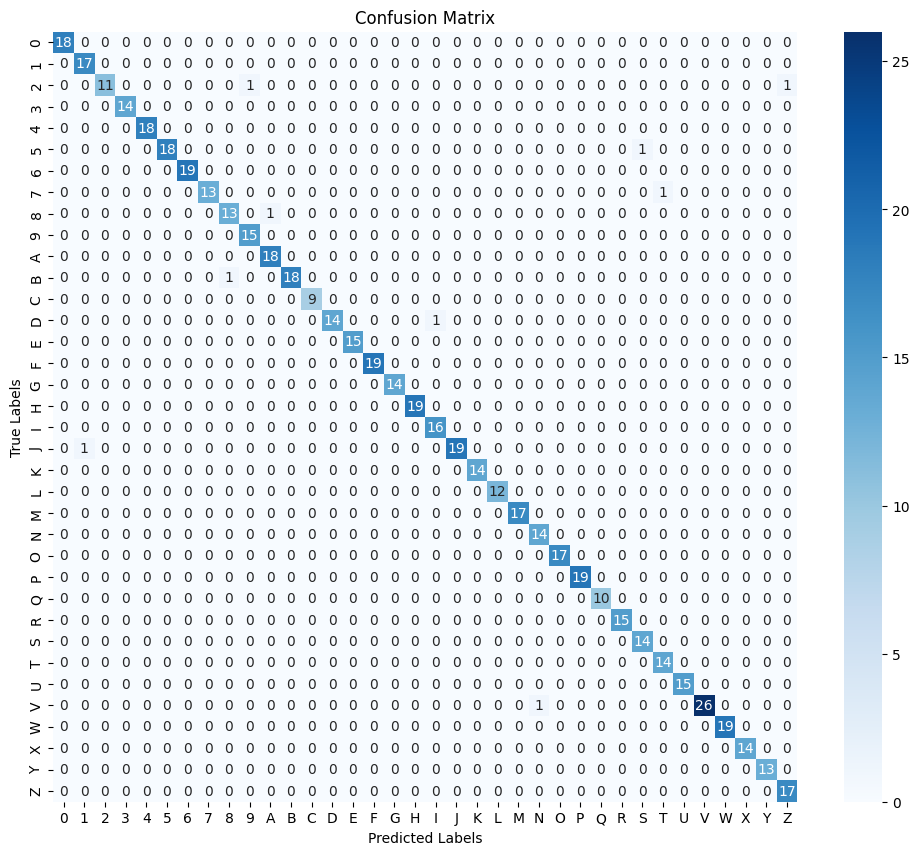

In [7]:
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [12]:
# Calculate and display classification report (including precision, recall, F1-score)
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       0.94      1.00      0.97        17
           2       1.00      0.85      0.92        13
           3       1.00      1.00      1.00        14
           4       1.00      1.00      1.00        18
           5       1.00      0.95      0.97        19
           6       1.00      1.00      1.00        19
           7       1.00      0.93      0.96        14
           8       0.93      0.93      0.93        14
           9       0.94      1.00      0.97        15
           A       0.95      1.00      0.97        18
           B       1.00      0.95      0.97        19
           C       1.00      1.00      1.00         9
           D       1.00      0.93      0.97        15
           E       1.00      1.00      1.00        15
           F       1.00      1.00      1.00        19
           G       1.00      1.00      1.00        14
    

# Testing

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Predicted Class: 4
Confidence: 23.447567


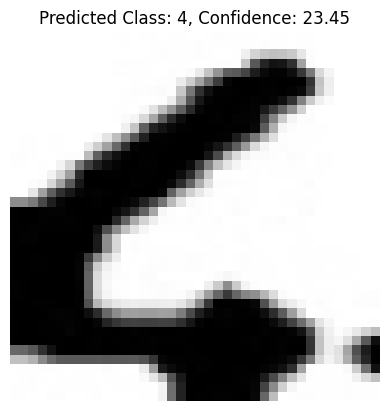

In [29]:
image_path = 'Dataset\\4. Threshold\\4\\augmented_8d8293ebf76c783e5041b0d6b8690ef3ae7c2098_jpg.rf.7ca9adf2a72e8dd4c200d993d3bec6d5.jpg'
model = tf.keras.models.load_model('..\..\models\coba100epoch.keras')
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B',
               'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N',
               'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

img = cv2.imread(image_path)
img = cv2.resize(img, (40, 40))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
img_array = img_array / 255.0

predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions[0])
predicted_class_name = class_names[predicted_class_index]
confidence_score = np.max(predictions[0])

print("Predicted Class:", predicted_class_name)
print("Confidence:", confidence_score)

plt.imshow(img)
plt.title(f"Predicted Class: {predicted_class_name}, Confidence: {confidence_score:.2f}")
plt.axis('off') 
plt.show()